# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом  разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Требуется построить модель для определения стоимости. 


**Описание данных**
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `NotRepaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

*Целевой признак*

* `Price` — цена (евро) 

## Подготовка данных

Загрузка библиотек, чтение данных из файла, получение основной информации о данных

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-whitegrid')
pd.set_option('mode.chained_assignment', None)
from tqdm import tqdm
from scipy import stats as sts
from scipy import special as spc

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor

import time
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.impute import SimpleImputer
set_config(display='diagram') 

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV


import lightgbm as lgbm

RANDOM_STATE = 26

In [3]:
url = 'https://drive.google.com/uc?id=' + 'https://drive.google.com/file/d/1Ra-j_sPUqG65nFlqwC9utXzbGOGM3QzC/view?usp=sharing'.split('/')[-2]
data = pd.read_csv(url)

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
num_columns = (data.
               drop(['PostalCode', 'NumberOfPictures'], axis=1).
               dtypes[data.dtypes !='object'].
               index.
               values)
cat_columns = (data.
               drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1).
               dtypes[data.dtypes =='object'].
               index.
               values)

In [7]:
data[num_columns].describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645
std,4514.158514,90.227958,189.850405,37905.341530,3.726421
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


In [8]:
data[cat_columns].describe()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,316879,334536,334664,321474,354369,283215
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,91457,268251,29232,216352,77013,247161


In [9]:
data.Gearbox.value_counts().values

array([268251,  66285])

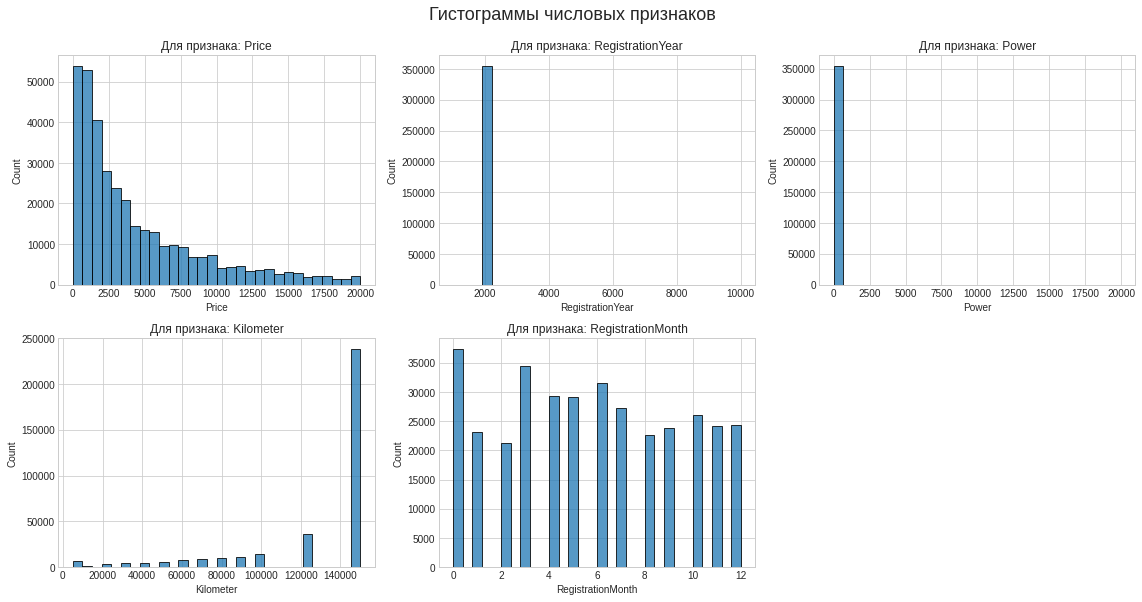

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(16,8))
fig.suptitle('Гистограммы числовых признаков', y=1.04, fontsize=18)
ax = ax.ravel()

for i in range(len(num_columns)):
  sns.histplot(data=data, x=data[num_columns[i]], ax=ax[i], bins=30)
  ax[i].set_title(f'Для признака: {num_columns[i]}')
  

fig.delaxes(ax[5])
fig.tight_layout()
fig.show()

По гистограммам видно, что имеются аномальные значения для признаков: *Price*, *RegistrationYear*, *Power*.

Посмотрим на целевую переменную поближе.

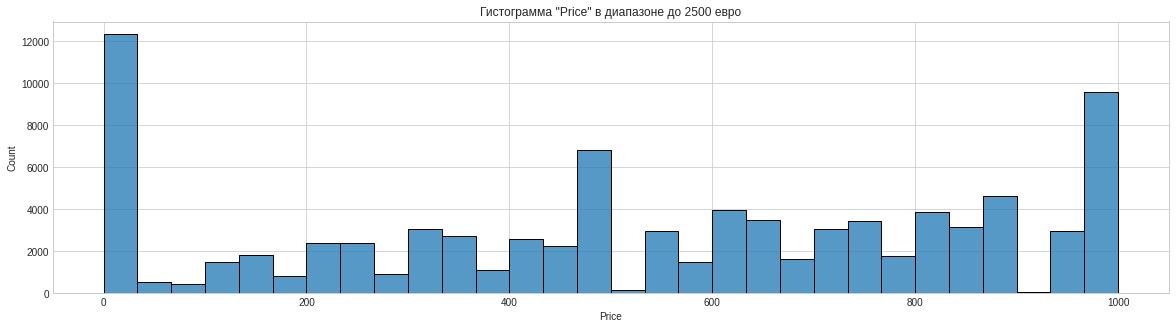

In [11]:
plt.figure(figsize=(20,5))
sns.histplot(data[data['Price'] <= 1000]['Price'], bins=30)
plt.title('Гистограмма "Price" в диапазоне до 2500 евро')
plt.show()

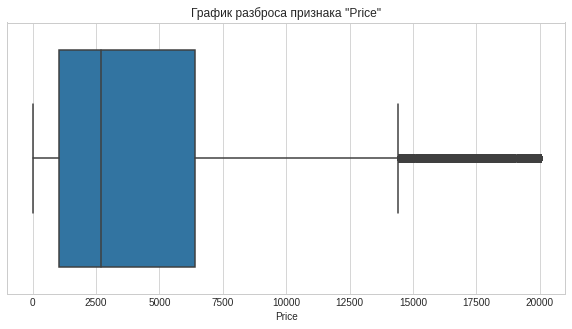

In [12]:
plt.figure(figsize=(10,5))
sns.boxplot(x=data['Price'])
plt.title('График разброса признака "Price"')
plt.show()

Высокие значения цены могут быть у люксовых автомобилей, а вот околонулевые значения не нужны. Удалю из выборки объявления, где цена ниже 200 евро.

In [13]:
data = data[data['Price'] >= 200]

Поиск и удаление дубликатов

In [14]:
print('Количество дубликатов в данных:', data.duplicated().sum())

Количество дубликатов в данных: 4


Однако, одно и то же объявление могло быть загружено в разное время. А также такие столбцы, как: *Дата скачивания анкеты из базы*, *Дата создания анкеты* и *Дата последней активности пользователя* не относятся к характеристикам автомобиля, поэтому надо посчитать количество дублкатов без этих колонок.

In [15]:
print('количество дубликатов в данных без столбцов "DateCrawled", "DateCreated", "LastSeen":', data.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1).duplicated().sum())

количество дубликатов в данных без столбцов "DateCrawled", "DateCreated", "LastSeen": 20372


In [16]:
df = data[['DateCrawled', 'DateCreated', 'LastSeen']]
data = (data[data.
         columns.
         difference(['DateCrawled', 'DateCreated', 'LastSeen'])].
      drop_duplicates().
      join(df))

В признаке *Год регистрации автомобиля* много аномальных значений.

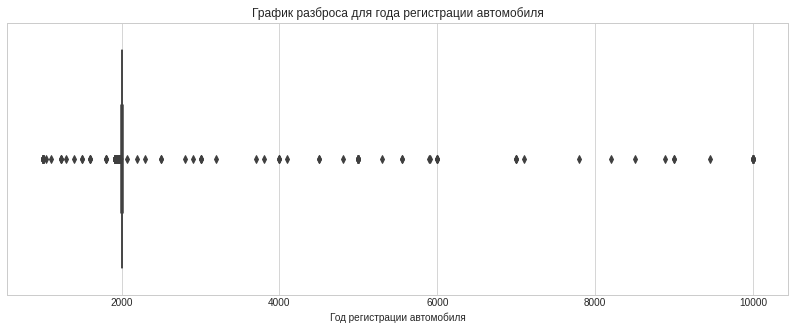

In [17]:
plt.figure(figsize=(14,5))
sns.boxplot(data=data, x='RegistrationYear')
plt.title('График разброса для года регистрации автомобиля')
plt.xlabel('Год регистрации автомобиля')
plt.show()

Очень много артефактов, как будто автомобили были зарегистрирвоаны еще до их изобретения и после создания анкеты. Такие данные надо удалить.

Для начала уберу аномальные данные. Чтобы выбрать, с какого значения величины *Год регистрации автомобиля* отсекать данные, построю гистограмму частот.

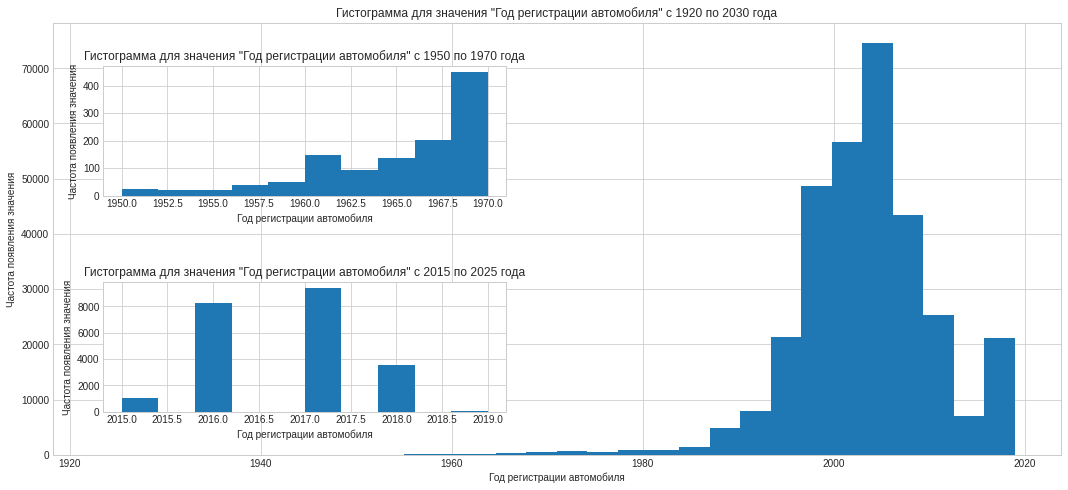

In [18]:
fig = plt.figure(figsize=(14,6))
axes1 = fig.add_axes([0,0,1,1])
axes1.hist(data.query('1920 <= RegistrationYear < 2030')['RegistrationYear'], bins=30)
axes1.set_title('Гистограмма для значения "Год регистрации автомобиля" с 1920 по 2030 года')
axes1.set_xlabel('Год регистрации автомобиля')
axes1.set_ylabel('Частота появления значения')

axes2 = fig.add_axes([0.05,0.6,0.4,0.3])
axes2.hist(data.query('1950 <= RegistrationYear <=1970')['RegistrationYear'],bins=10)
axes2.set_title('Гистограмма для значения "Год регистрации автомобиля" с 1950 по 1970 года')
axes2.set_xlabel('Год регистрации автомобиля')
axes2.set_ylabel('Частота появления значения')

axes3 = fig.add_axes([0.05,0.1,0.4,0.3])
axes3.hist(data.query('2015 <= RegistrationYear <= 2025')['RegistrationYear'],bins=10)
axes3.set_title('Гистограмма для значения "Год регистрации автомобиля" с 2015 по 2025 года')
axes3.set_xlabel('Год регистрации автомобиля')
axes3.set_ylabel('Частота появления значения')
plt.show()

Как видно из графика, все значения сосредоточены в интервале с 1990 по 2018, однако присутсвуют и более старые правдоподобные значения. Например, в период с 1950 по 1960 - 295 объявлений. 

Оставлю только объявления с 1950 года, так как более ранние автомобили скорее продаются через специализированные сайты среди ценителей ретро.

In [19]:
data = data[data['RegistrationYear'] >= 1950]
data = data[data['RegistrationYear'] <= 2018]

В столбце *месяц регистрации автомобиля* значений больше, чем месяцев в году. Возможно это связано с ошибками при переносе базы или с неправильным заролнением анкеты пользователем. Чтобы убрать нулевые значения, вместо них подставлю значения, случайным образом сгенерированные из равномерного распределения в интервале от 1 до 12.

In [20]:
data['RegistrationMonth'].value_counts()

3     31248
0     28833
6     28591
4     26737
5     26420
7     24818
10    23611
11    21977
12    21929
9     21588
1     20864
8     20485
2     19226
Name: RegistrationMonth, dtype: int64

In [21]:
random.seed(12)
data.loc[data['RegistrationMonth'] == 0, 'RegistrationMonth'] = ([random.randint(1, 12) for i in range(len(data[data['RegistrationMonth']==0]['RegistrationMonth']))])

Так как значения *год регистрации автомобиля* принимают максимальное значение - 2018, то для создания признака *возраст автомобиля* буду отсчитывать от декабря 2018.

In [23]:
data['age_years'] = 2018 - data['RegistrationYear']
num_columns = np.append(num_columns, 'age_years')

Признак *Power*. 

У данного признака есть как аномально низкие (нулевые), так и аномально высокие значения. Аномально высокие значения искажают статистические величины (среднее, дисперсию). Надо выбрать крайнее значение *Power*. Для этого нарисую гистограммы для *Power*, для значений в интервале от 200 (это довольно высокое и правдоподобное значение) и до 900 (вероятность, что такай автомобиль будут продавать в "Не бит, не крашен* очень мала).

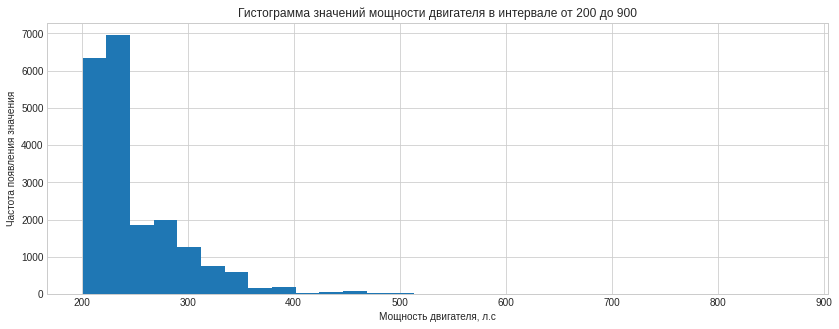

In [24]:
plt.figure(figsize=(14, 5))
data[(data['Power'] > 200) & (data['Power'] < 900)]['Power'].hist(bins=30)
plt.title('Гистограмма значений мощности двигателя в интервале от 200 до 900')
plt.xlabel('Мощность двигателя, л.с')
plt.ylabel('Частота появления значения')
plt.show()

После 400 еще случаются единичные случаи, поэтому ограничу значением 500.

In [25]:
data = data[data['Power'] < 500]

In [26]:
print('Количество нулевых значений признака Power:', data[data['Power'] == 0]['Power'].count())

Количество нулевых значений признака Power: 32214


Нулевых же значений довольно много и избавление от них значительно уменьшит выборку, но и нулевые значения могут ухудшить работу модели. Так как это явно ошибочные данные, то их придется заменить. Заменю их средним значением по сгруппированным данным по признакам *Brand* и *Model*. 

In [27]:
data.loc[data['Power'] == 0, 'Power'] =  (data.groupby(['Brand', 'Model'])['Power'].
                                      transform('mean').
                                      drop(data[data['Power']==0].index))

In [28]:
data.loc[data['Power'].isna(), 'Power'] =  (data.groupby(['Brand'])['Power'].
                                            transform('mean')
                                            )

Посмотрю, как признаки коррелированы между собой.

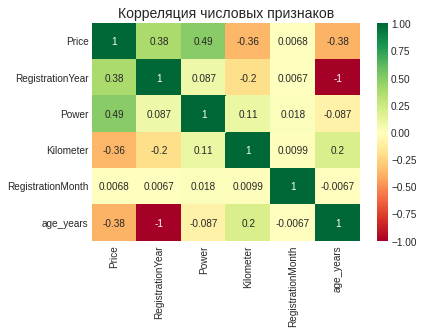

In [29]:
sns.heatmap(data[num_columns].corr(), cmap='RdYlGn', annot=True)
plt.title('Корреляция числовых признаков', fontsize=14)

plt.show()

Линейной зависимости между признаками нет. Наибольшую линейную зависимсоть с целевой переменной имеют признаки мощности и пробега. 

Категориальные признаки *'VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired'* имеют пропущенные значения, но восстановление их значений по другим данным может привести к большим погрешностям в работе моделей, поэтому заполню значением *unknown*.




признаки *PostalCode*, *RegistrationMonth*, *DateCrawled*, *DateCreated*, *LastSeen* можно удалить.

In [30]:
data = data[['Brand', 'FuelType', 'Gearbox',  'Model', 'NotRepaired', 'VehicleType', 'Power', 'age_years','Kilometer', 'Price']]

## Подготовка признаков

In [31]:
train = data.drop('Price', axis=1)
target = data['Price']

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=RANDOM_STATE)

Попробую использовать преобразование Бокса-Кокса для целевой переменной, чтобы приблизить ее распределение к нормальному

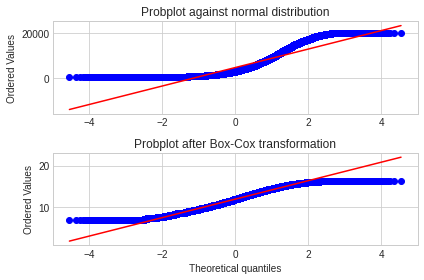

In [32]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = sts.probplot(y_train, dist=sts.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
y_train_bx, lambda_bc = sts.boxcox(y_train)
prob = sts.probplot(y_train_bx, dist=sts.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
fig.tight_layout()
plt.show()

**Пайплайн по предварительной подготовке данных**

In [33]:
num_columns = (data.drop('Price', axis=1).
               select_dtypes(include=['int64', 'float64']).
               columns)
cat_columns = data.select_dtypes(include=['object']).columns

numeric_transformer = make_pipeline(StandardScaler())
cat_transformer = make_pipeline(SimpleImputer(strategy='constant', 
                                              fill_value='unknown'), 
                                OneHotEncoder(drop='first', handle_unknown='ignore'))

In [34]:
prep_reg = ColumnTransformer(
    transformers=[
                  ('num', numeric_transformer, num_columns),
                  ('cat', cat_transformer, cat_columns)
    ]
)

prep_rf = ColumnTransformer(
    transformers=[
                  ('num', numeric_transformer, num_columns)
                  
    ]
)

Целевой признак - количественный, значит имеет место задача регрессии. В данных много пропусков и аномальных значений. В основном, пропуски заполнить нежелательно, потому что это значительно ухудшит предсказания модели на реальных данных. Модель будет лучше работать, если пользователь будет максимально полно заполнять поля анкеты объявления.


## Обучение моделей

**Случайная модель**

In [35]:
dummy = pd.Series(y_train.mean(), index=y_test.index)
print('Значение rmse для случайной модели: ', mean_squared_error(y_test, dummy)**0.5)

Значение rmse для случайной модели:  4496.419220477914


**Диапазон поиска гиперпараметров**

In [36]:
params_reg = {'ridge__alpha' : np.linspace(0.1, 3, 20)}

params_rf = {
    'randomforestregressor__max_depth' : [None, 1, 4, 7, 10],
    'randomforestregressor__n_estimators' : np.arange(1, 201, 10),
    'randomforestregressor__bootstrap' : [True, False]
}

params_lgb = {
    'lgbmregressor__max_depth' : np.arange(1, 10),
    'lgbmregressor__n_estimators' : np.arange(600, 1301, 100),
    'lgbmregressor__learning_rate' : np.linspace(0.1, 1, 20),
    'lgbmregressor__num_leaves' : np.arange(700, 1601, 100)
  
}

In [37]:
models = {'ridge' : {'model' : Ridge(random_state=RANDOM_STATE),
                    'params' : params_reg,
                     'prep' : prep_reg
                     },
          'randomforest' : {'model' : RandomForestRegressor(random_state=RANDOM_STATE),
                            'params' : params_rf,
                            'prep' : prep_rf
                            },
          'lgbm' : {'model' : lgbm.LGBMRegressor(random_state=RANDOM_STATE),
                    'params' : params_lgb,
                    'prep' : prep_reg
                    }
          }

**функции для обучения и тестирования моделей**

In [38]:
def train_model(models, X_train, y_train):
  best_model = None
  best_score = 100000
  result = pd.DataFrame()

  toc = time.perf_counter()
  for model in models:
    pipe = make_pipeline(models[model]['prep'], models[model]['model'])
    search = RandomizedSearchCV(pipe, 
                                models[model]['params'], 
                                n_iter=20, 
                                scoring='neg_root_mean_squared_error', 
                                cv=5, 
                                n_jobs=-1,
                                random_state=RANDOM_STATE,
                                refit=True)

    
    #print(best_score)
    search.fit(X_train, y_train)
    tic = time.perf_counter()
    train_time = tic - toc
    buff = pd.DataFrame({'params' : search.best_params_, 
                         'score' : -search.best_score_,
                         'train_time' : train_time})
    result = pd.concat([result, buff])
    rmse = -search.best_score_
    if rmse < best_score:
      best_model = search
      best_score = -search.best_score_

    
  
  return best_model, result


In [39]:
def test_model(search, X_test, y_test, boxcox=False):
  toc = time.perf_counter()
  preds = search.predict(X_test)
  if boxcox:
    preds = spc.inv_boxcox(preds, lambda_bc)
  
  return mean_squared_error(y_test, preds)**0.5


In [40]:
search, results = train_model(models, X_train, y_train)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


In [41]:
rmse = test_model(search, X_test, y_test, False)
display(results)
print('Для модели без преобразование Бокса-Кокса rmse:', rmse)


Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros


,params,score,train_time
ridge__alpha,1.778947,2644.678251,118.699888
randomforestregressor__bootstrap,False,2178.144944,1325.806839
randomforestregressor__max_depth,10,2178.144944,1325.806839
randomforestregressor__n_estimators,161,2178.144944,1325.806839
lgbmregressor__learning_rate,0.384211,1626.841283,2473.643430
lgbmregressor__max_depth,8.0,1626.841283,2473.643430
lgbmregressor__n_estimators,900.0,1626.841283,2473.643430
lgbmregressor__num_leaves,1400.0,1626.841283,2473.643430


Для модели без преобразование Бокса-Кокса rmse: 1594.550470116563


In [42]:
search_bc, results_bc = train_model(models, X_train, y_train_bx)

In [43]:
rmse_bc = test_model(search_bc, X_test, y_test, True)
display(results_bc)
print('Для модели с преобразованием Бокса-Кокса rmse:', rmse_bc)

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros


,params,score,train_time
ridge__alpha,1.015789,1.268644,118.646322
randomforestregressor__bootstrap,False,1.178428,1332.648068
randomforestregressor__max_depth,10,1.178428,1332.648068
randomforestregressor__n_estimators,161,1.178428,1332.648068
lgbmregressor__learning_rate,0.431579,0.875913,2520.587086
lgbmregressor__max_depth,5.0,0.875913,2520.587086
lgbmregressor__n_estimators,1200.0,0.875913,2520.587086
lgbmregressor__num_leaves,1600.0,0.875913,2520.587086


Для модели с преобразованием Бокса-Кокса rmse: 1670.4354352762969


### Вывод
Наилучший результат показала модель LGBMRegressor, в которой целевая переменная не подвергалась преобразованию Бокса-Кокса. Однако, время обучения такой модели выше чем модели случайного леса и значительно выше, чем у модели линейной регрессии

Важность признаков для моделей

In [44]:
model = Ridge(alpha=1.778947)
X_train_transformed = prep_reg.fit_transform(X_train)
model.fit(X_train_transformed, y_train)
cat_columns_pipe = list(prep_reg.transformers_[1][1].named_steps['onehotencoder'].get_feature_names_out())
feature_names = cat_columns_pipe + list(num_columns)
pd.Series(model.coef_, index=feature_names).sort_values(ascending=False).head(20)

x3_kangoo               6333.274784
x3_a_klasse             5790.183320
x3_niva                 5543.662134
x3_r19                  5386.647058
x3_getz                 5278.390062
x3_range_rover          5148.170740
x3_lanos                4705.651327
x3_cherokee             4661.823563
x3_a4                   4367.721523
x0_saab                 4264.967940
x3_touran               4069.845684
x3_range_rover_sport    3874.746023
x3_x_type               3832.187374
x3_spark                3708.041034
x3_superb               3637.838341
x3_vectra               3388.813900
x3_doblo                3375.797000
x3_i3                   3371.522687
x1_electric             3309.618148
x3_4_reihe              3260.106547
dtype: float64

In [45]:
model = lgbm.LGBMRegressor(learning_rate=0.43157894736842106, max_depth=5, n_estimators=1200, num_leaves=1600, random_state=RANDOM_STATE)
pipe = make_pipeline(prep_reg, model)
pipe.fit(X_train, y_train)
cat_columns_pipe = list(pipe[0].transformers_[1][1].named_steps['onehotencoder'].get_feature_names_out())
feature_names = cat_columns_pipe + list(num_columns)

In [47]:
pd.Series(pipe[1].feature_importances_, index=feature_names).sort_values(ascending=False).head(20)

x0_bmw          5852
x0_audi         5180
x0_chevrolet    2713
x3_147           505
x1_other         415
x5_coupe         407
x5_unknown       331
x5_other         313
x2_unknown       307
x5_sedan         259
x3_panda         217
x5_small         201
age_years        191
Kilometer        179
x5_wagon         156
Power            156
x3_145           140
x3_156           129
x3_twingo        124
x0_toyota        108
dtype: int64